# Analyzes data from the static and swing text files, fits them to nonlinear equations, and outputs a sensitivity with uncertainty.

In [1]:
# all global variables that you'd want to change are in the cell
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

names = 'count, timestamp, temp,  x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro'
path_swing= r"C:\Users\mhanr\Desktop\NIST\Data\7-15\W6.txt"
path_stat = r"C:\Users\mhanr\Desktop\NIST\Data\7-15\T6.txt"

swing_data = np.genfromtxt(path_swing, names = names, skip_footer = 1)
stat_data = np.genfromtxt(path_stat, names = names, skip_footer = 1)

AX_OFFSET = 252.42 # comes from cube calibration
GLOC = 9.80258 # local acceleration of gravity from https://www.ngs.noaa.gov/cgi-bin/grav_pdx.prl
dGloc = 0.00002 # if I ever need it

Ax summary stats:
Mean: 16289.764999999996
2 Stdev:  259.08431658439036 

Gz summary stats:
Mean: -919.608
2 Stdev:  293.9005841164662 



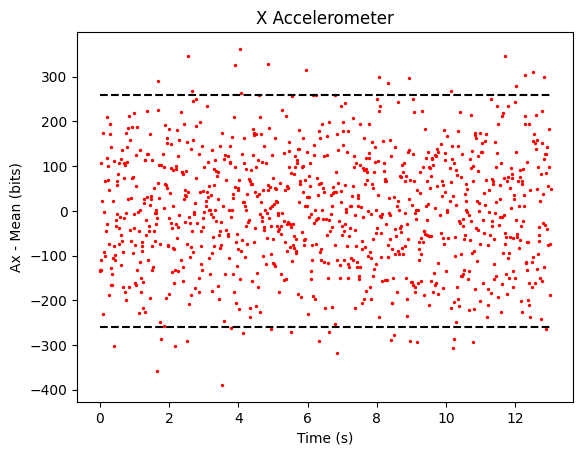

Text(0.5, 0, 'Time (s)')

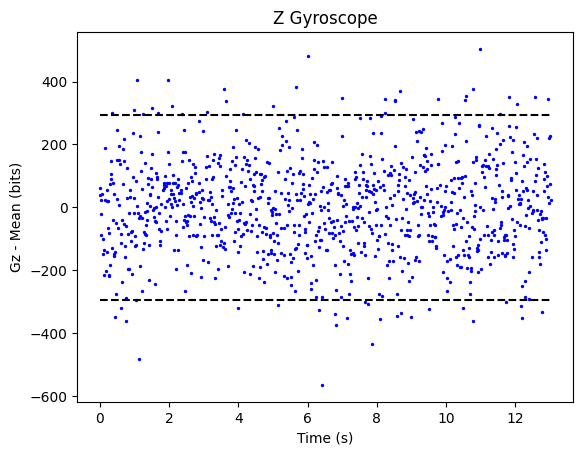

In [2]:
stat_time = stat_data['timestamp']
stat_time -= stat_time[0] # makes the first entry zero, should help with the fit
stat_count = stat_data['count']
stat_ax_o = stat_data['x_accel'] - AX_OFFSET
stat_gz = stat_data['z_gyro']

stat_ax_resids = stat_ax_o - np.average(stat_ax_o)
stat_gz_resids = stat_gz - np.average(stat_gz)

print('Ax summary stats:')
print('Mean:', np.average(stat_ax_o))
print('2 Stdev: ', 2*np.std(stat_ax_o), '\n')

print('Gz summary stats:')
print('Mean:', np.average(stat_gz))
print('2 Stdev: ', 2*np.std(stat_gz), '\n')

plt.scatter(stat_time, stat_ax_resids, s = 2, c = 'r')
plt.plot(stat_time, [2*np.std(stat_ax_o)]*len(stat_time), 'k--')
plt.plot(stat_time, [-2*np.std(stat_ax_o)]*len(stat_time), 'k--')
plt.title('X Accelerometer')
plt.ylabel('Ax - Mean (bits)')
plt.xlabel('Time (s)')
plt.show()

plt.scatter(stat_time, stat_gz_resids, s = 2, c = 'b')
plt.plot(stat_time, [2*np.std(stat_gz)]*len(stat_time), 'k--')
plt.plot(stat_time, [-2*np.std(stat_gz)]*len(stat_time), 'k--')
plt.title('Z Gyroscope')
plt.ylabel('Gz - Mean (bits)')
plt.xlabel('Time (s)')

In [3]:
gz_offset = np.average(stat_gz)

swing_time = swing_data['timestamp']
swing_time -= swing_time[0]
swing_count = swing_data['count']
swing_ax_o = swing_data['x_accel'] - AX_OFFSET
swing_gz_o = swing_data['z_gyro'] - gz_offset

swing_ax_resids = swing_ax_o - np.average(swing_ax_o)
swing_gz_resids = swing_gz_o - np.average(swing_gz_o)

In [4]:
# this is where the fun begins
def accel(x, g, k, d, e, f):
    return g * np.exp(-k*x) * np.cos( (d*np.cos(w*x)+e*np.sin(w*x))) + f
def gyro(t, k, w, a, b, c):
    return np.exp(-k*t) * ( w * ( a * np.cos(w*t) + b * np.sin(w*t) ) ) + c

In [5]:
from scipy.optimize import curve_fit
# this is where the actual fitting begins
accel_guesses =  [9213.75,  0.00181236, -0.0498, -1.0013, 9876.6] # you will likely need to change this!
gyro_guesses = [0.007126082, 5.148, 5753.85, -271.69, 16.24] # and this!

popt1, pcov1 = curve_fit(gyro, swing_time, swing_gz_o, gyro_guesses)
w = popt1[1] # needed for the next fit!
popt0, pcov0 = curve_fit(accel, swing_time, swing_ax_o, accel_guesses)

g, k, d, e, f = popt0
k, w, a, b, c = popt1

dg, dk, dd, de, df = np.sqrt(np.diag(pcov0))
dk, dw, da, db, dc = np.sqrt(np.diag(pcov1))

A = np.average(stat_ax_o)
dA = np.std(stat_ax_o)

params = [a,b,d,e,f,g,A]
uncerts = [da, db, dd, de, df, dg, dA]

In [6]:
accel_fit = accel(swing_time, *popt0)
gyro_fit = gyro(swing_time, *popt1)

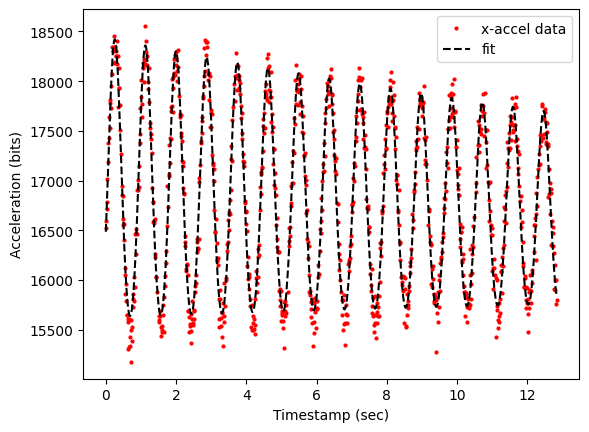

Text(0, 0.5, 'Gyroscopic Acceleration (bits)')

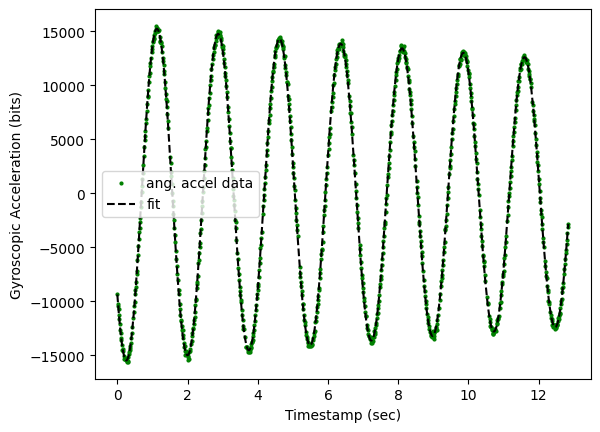

In [7]:
plt.plot(swing_time, swing_ax_o, 'ro', label = 'x-accel data', markersize = 2)
plt.plot(swing_time, accel_fit, 'k--', label = 'fit')
plt.legend()
plt.xlabel('Timestamp (sec)')
plt.ylabel("Acceleration (bits)")
plt.show()

plt.plot(swing_time, swing_gz_o, 'go', label = 'ang. accel data', markersize = 2)
plt.plot(swing_time, gyro_fit, 'k--', label = 'fit')
plt.legend()
plt.xlabel('Timestamp (sec)')
plt.ylabel('Gyroscopic Acceleration (bits)')

In [8]:
# here I print summary stats that gaitan does
Astatic = np.average(stat_ax_o)
Amin = g*np.cos(np.sqrt(d**2 + e**2))+ f
theta_0_rad= np.arccos(1-(Astatic-Amin)/(Astatic))
theta_0 = np.degrees(theta_0_rad)
Gm = theta_0*w
Max_Gz = np.sqrt(a**2 + b**2)*w
Sensitivity = Gm/Max_Gz
datasheet = 4.375 # mdps/bit
difference = ((datasheet / 1000) - Sensitivity) / (datasheet / 1000)

print('Astatic:', Astatic, 'bits')
print('Amin:', Amin, 'bits')
print('Theta 0:', theta_0, 'deg')
print('Gm = theta0*w:', Gm, 'dps')
print(Max_Gz, 'bits')
print(Sensitivity, 'dps/bit')
print(Sensitivity*1000, 'mdps/bit')
print('difference: ', "{:.2%}".format(difference))
print('L = g0/w2 =', GLOC / w**2, 'm')

Astatic: 16289.764999999996 bits
Amin: 15629.006681682778 bits
Theta 0: 16.37497317487581 deg
Gm = theta0*w: 58.97145802485733 dps
15563.539511462912 bits
0.0037890775412253407 dps/bit
3.789077541225341 mdps/bit
difference:  13.39%
L = g0/w2 = 0.7558190932314356 m


In [9]:
def S(a,b,d,e,f,g,A):
    # returns sensitivity in dps.bit
    return 180/np.pi * 1/(np.sqrt(a**2 + b**2))* np.arccos((g*np.cos(np.sqrt(d**2 + e**2)) + f) / A)

In [10]:
import sympy as sp # a python-based symbolic manipulator
# a list of symbols to represent the independent variables
symbols = a_s,bs,ds,es,fs,gs,As = sp.symbols('a b d e f g A')
# the equation for sensitivty that uses our indep variable symbols (dps/bit):
S_sym = (180 / np.pi) *(1/((a_s**2 + bs**2))**(0.5)* sp.acos(((gs*sp.cos((ds**2 + es**2)**(0.5)) + fs))/ (As)))

def grad_func():
    # returns the matrix of numerical partial deriviatves (i.e., the gradient)
    sym_partial_derivs = [sp.diff(S_sym, var) for var in symbols]
    grad = []
    for func in sym_partial_derivs:
        func = sp.lambdify(symbols, func, 'numpy')
        grad.append(func(a,b,d,e,f,g,A))
    return grad

gradient = grad_func() # our gradient
mysum = 0
for i in range(len(gradient)):
    mysum += (gradient[i] * uncerts[i])**2

In [11]:
print('sensitivity', S(a,b,d,e,f,g,A)*1000, 'mdps/bit')
print('uncertainty in sensitivity: ', np.sqrt(mysum)*1000, 'mdps/bit')

sensitivity 3.7890775412253412 mdps/bit
uncertainty in sensitivity:  0.4198913028269292 mdps/bit
